# Milestone 2: Advanced Data Analysis and Feature Engineering

## Imports:

In [15]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import chi2, f_classif, SelectKBest, RFE
from sklearn.linear_model import LogisticRegression


### 1) Load the data:

In [16]:
df = pd.read_csv(r"E:\Customer-Churn-Prediction-and-Analysis\Data\cleaned_churn_data.csv")
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn,has_contract
0,15,True,False,11.95,25,0.14,0,8.4,2.3,0,False,True
1,18,False,False,8.22,0,0.00,0,0.0,0.0,0,True,False
2,23,True,False,8.91,16,0.00,0,13.7,0.9,0,True,False
3,27,False,False,6.87,21,0.00,1,0.0,0.0,0,True,False
4,34,False,False,6.39,0,0.00,0,0.0,0.0,0,True,False


- ## 2) Removes spaces & missing data
    - #### Converts booleans (True/False) to 0/1


In [17]:
df.columns = df.columns.str.strip()
df.dropna(inplace=True)
bool_cols = ['is_tv_subscriber', 'is_movie_package_subscriber', 'has_contract', 'churn']
df[bool_cols] = df[bool_cols].astype(int)
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn,has_contract
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0,1
1,18,0,0,8.22,0,0.00,0,0.0,0.0,0,1,0
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1,0
3,27,0,0,6.87,21,0.00,1,0.0,0.0,0,1,0
4,34,0,0,6.39,0,0.00,0,0.0,0.0,0,1,0


## 3) Advanced Data Analysis

C:\Users\almasry net\AppData\Local\Temp\ipykernel_6660\1480680112.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




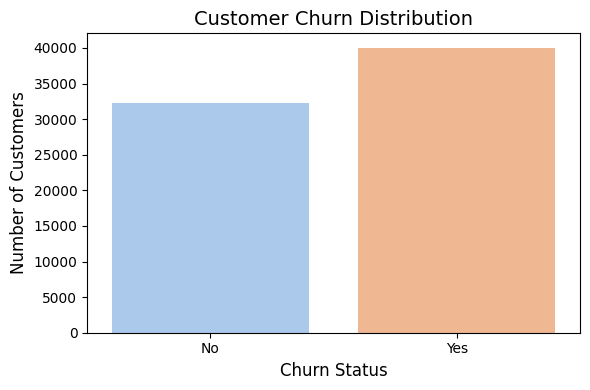

In [18]:
# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df, palette='pastel')
plt.title("Customer Churn Distribution", fontsize=14)
plt.xlabel("Churn Status", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

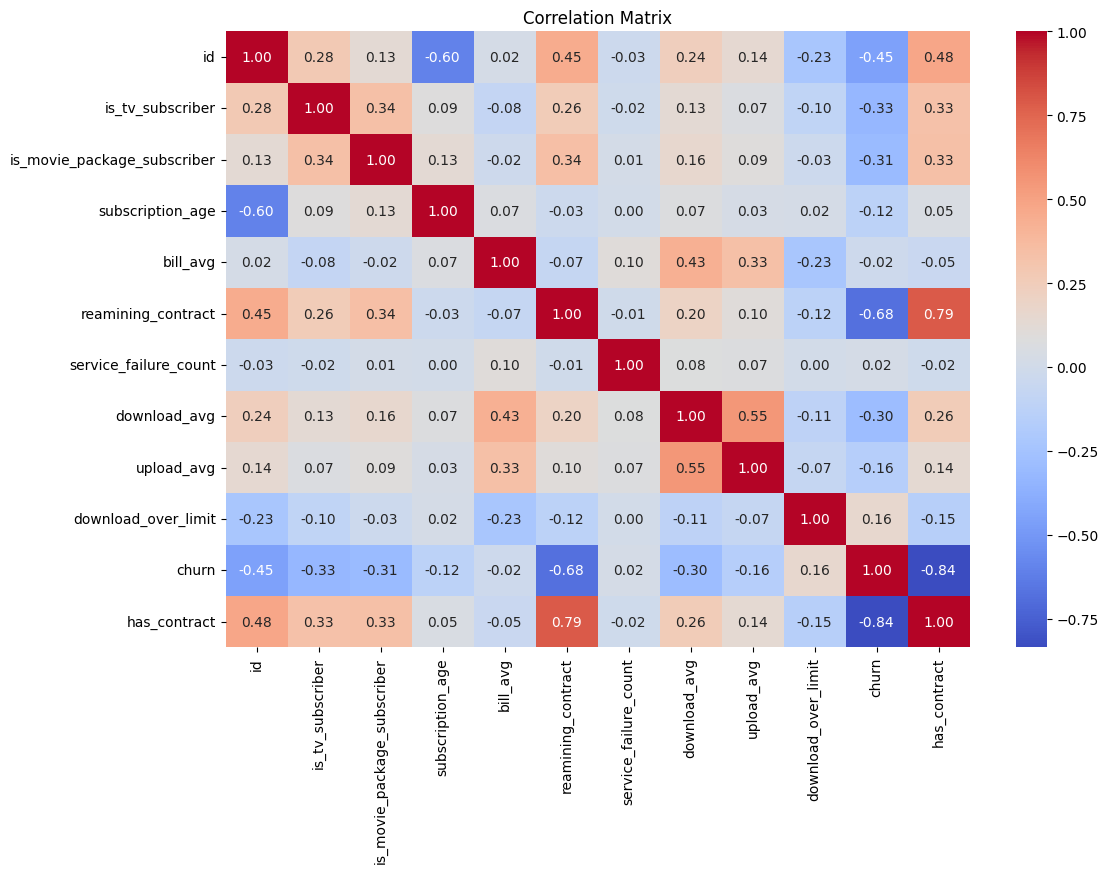

In [19]:
#  Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [20]:
# Chi-squared test for categorical features
X_cat = df[bool_cols]
y = df['churn']
chi_scores = chi2(X_cat, y)
chi_results = pd.DataFrame({'Feature': X_cat.columns, 'Chi2': chi_scores[0], 'p-value': chi_scores[1]})
print("🔹 Chi-squared Test Results:\n", chi_results.sort_values('Chi2', ascending=False))

🔹 Chi-squared Test Results:
                        Feature          Chi2  p-value
3                        churn  32224.000000      0.0
2                 has_contract  26480.113802      0.0
1  is_movie_package_subscriber   4537.277652      0.0
0             is_tv_subscriber   1432.804997      0.0


In [21]:
# 🔍 ANOVA F-test for numerical features
X_num = df.select_dtypes(include=['float64', 'int64']).drop(columns=['id', 'churn'])
f_values, p_values = f_classif(X_num, y)
anova_df = pd.DataFrame({'Feature': X_num.columns, 'F-Value': f_values, 'p-value': p_values})
print("\n🔹 ANOVA F-Test Results:\n", anova_df.sort_values('F-Value', ascending=False))


🔹 ANOVA F-Test Results:
                        Feature        F-Value        p-value
9                 has_contract  167070.257319   0.000000e+00
4           reamining_contract   62713.303645   0.000000e+00
0             is_tv_subscriber    8687.808425   0.000000e+00
1  is_movie_package_subscriber    7529.395228   0.000000e+00
6                 download_avg    6917.377677   0.000000e+00
7                   upload_avg    1920.227647   0.000000e+00
8          download_over_limit    1858.048461   0.000000e+00
2             subscription_age    1099.969442  2.129323e-239
5        service_failure_count      33.655440   6.606404e-09
3                     bill_avg      32.063003   1.498171e-08


In [22]:
#  Recursive Feature Elimination
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_num, y)
print("\n🔹 Top RFE Features:")
for i, feature in enumerate(X_num.columns):
    if rfe.support_[i]:
        print(f"- {feature}")


🔹 Top RFE Features:
- is_tv_subscriber
- subscription_age
- reamining_contract
- download_over_limit
- has_contract


##  4. Feature Engineering


In [23]:
# New feature: Total data usage (download + upload)
df['total_usage'] = df['download_avg'] + df['upload_avg']

# New feature: Customer lifetime value (bill * age)
df['customer_lifetime_value'] = df['bill_avg'] * df['subscription_age']

# Normalize selected features
scaler = MinMaxScaler()
scaled_cols = ['subscription_age', 'bill_avg', 'reamining_contract', 'download_avg', 'upload_avg']
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])
df.head()


,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn,has_contract,total_usage,customer_lifetime_value
0,15,1,0,0.933697,0.061576,0.047945,0,0.001903,0.005074,0,0,1,10.7,298.75
1,18,0,0,0.642746,0.000000,0.000000,0,0.000000,0.000000,0,1,0,0.0,0.00
2,23,1,0,0.696568,0.039409,0.000000,0,0.003103,0.001985,0,1,0,14.6,142.56
3,27,0,0,0.537441,0.051724,0.000000,1,0.000000,0.000000,0,1,0,0.0,144.27
4,34,0,0,0.500000,0.000000,0.000000,0,0.000000,0.000000,0,1,0,0.0,0.00


##  5) Visualizations & Dashboards

In [24]:
# Segmentation of churned vs non-churned by contract
fig = px.histogram(df, x="has_contract", color="churn", barmode="group",
                   title="Churn by Contract Status", labels={"has_contract": "Has Contract"})
fig.show()

In [25]:
# Scatter of bill vs. age colored by churn
fig = px.scatter(df, x='subscription_age', y='bill_avg', color='churn',
                 title='Bill vs. Age of Subscription Colored by Churn')
fig.show()

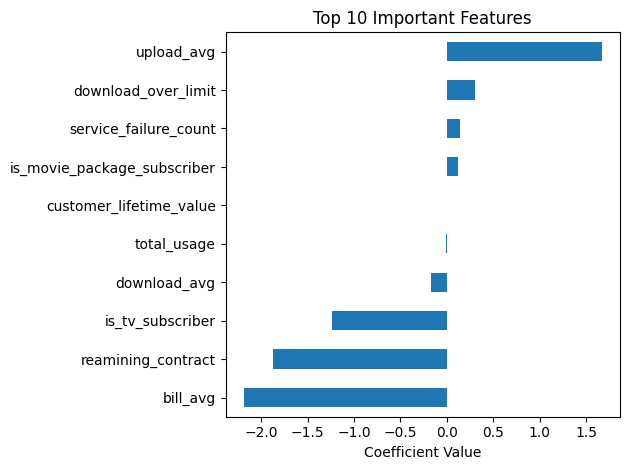

In [26]:
# Feature importance (from logistic regression)
X = df.drop(columns=['id', 'churn'])
y = df['churn']
model.fit(X, y)
importance = pd.Series(model.coef_[0], index=X.columns)
importance.nlargest(10).sort_values().plot(kind='barh', title='Top 10 Important Features')
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()